In [1]:
suppressMessages({library(tidyverse)
library(Seurat)
library(clusterProfiler)
library(org.Hs.eg.db)})

In [2]:
rds=readRDS("/SGRNJ02/RandD4/Integratedanalysis/virus_panel/20210107/amulti/virus.diff_PRO.rds")
df=read_tsv("/SGRNJ02/RandD4/virus_panel/20210102/S20201218_EBV__EBV_KZ/05.analysis_capture_virus/S20201218_EBV__EBV_KZ_tsne.tsv")

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  barcode = col_character(),
  tSNE_1 = col_double(),
  tSNE_2 = col_double(),
  cluster = col_double(),
  Gene_Counts = col_double(),
  tag = col_character(),
  UMI = col_double()
)



In [3]:
do_go <- function(genes){
    converted <- select(org.Hs.eg.db, 
       keys = genes,
       columns = c("ENTREZID", "SYMBOL"),
       keytype = "SYMBOL")

    gene_id <- na.omit(converted$ENTREZID)

    ego <- enrichGO(gene          = gene_id,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
        readable      = TRUE)
    return (ego)
}

In [4]:
df$shi<-c('S20201218_EBV__EBV_')
df$barcode<-str_c(df$shi,df$barcode)
df<-df[,-9]

In [5]:
meta = rds@meta.data
meta$vir = 'Not_detected'
df.vir = df[grepl('EBV', df$tag),]
df.vir=df.vir[df.vir$UMI>5,]
vir.barcode = df.vir$barcode
meta[vir.barcode,'vir'] = 'EBV'
rds@meta.data=meta
new.cluster.ids <- c('Tcells','Tcells','Monocytes','Bcells','Tcells','Endothelial cells','Plasma cells')
names(new.cluster.ids) <- levels(rds)
rds <- RenameIdents(rds, new.cluster.ids)
rds <- StashIdent(object = rds, save.name = "ClusterNames")

With Seurat 3.X, stashing identity classes can be accomplished with the following:
rds[["ClusterNames"]] <- Idents(object = rds)



Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
Saving 6.67 x 6.67 in image



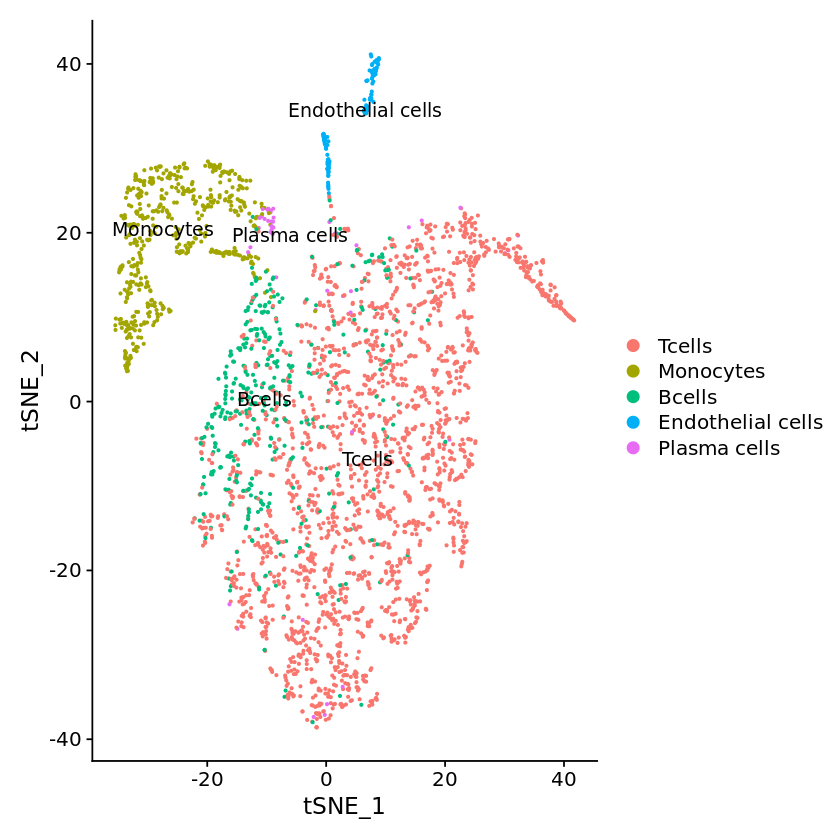

In [6]:
P<-TSNEPlot(object = rds,label = TRUE)
print(P)
ggplot2::ggsave(filename = "S20201218_EBV_EBV_lab_tsne.pdf")

Saving 6.67 x 6.67 in image



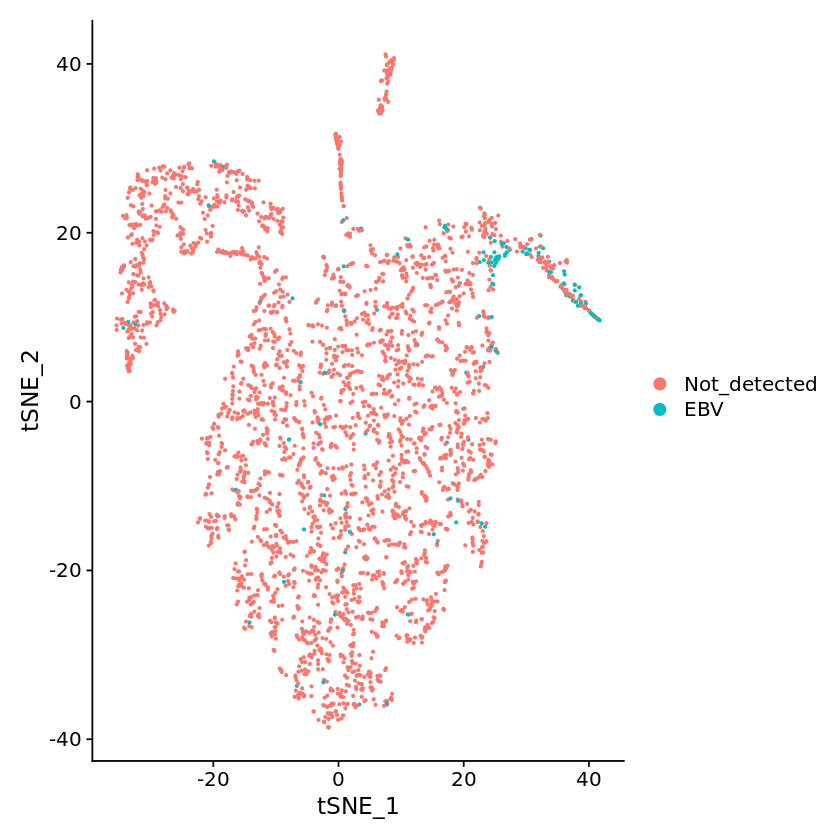

In [7]:
Idents(rds) <- "vir"
P<-TSNEPlot(object = rds)
print(P)
ggplot2::ggsave(filename = "S20201218_EBV_EBV_vir_tsne.pdf")

In [8]:
markergene=c('RAG1', 'RAG2', 'DCLRE1C', 'LIG4','IL2RG', 'JAK3', 'IL7RA','STIM1', 'RASGRP1' , 'CTPS1' , 'MST1', 'GATA2', 'DOCK8', 'WAS','CORO1A', 'PIK3CD‐GoF', 'PIK3R1', 'NFKB1','ITK', 'MAGT1','CD27', 'CD70', 'TNFRSF9')

In [9]:
Idents(rds) <- "vir"
cluster.markers <- FindMarkers(object=rds,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="EBV_diffgenes.xls",,sep='\t',quote=F,row.names=T)
#IFITM3<-FindMarkers(object=rds,ident.1="EBV",ident.2='Not_detected',features = markergene,logfc.threshold = 0)
#write.table(IFITM3,file="EBV_IFITM3diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "markergene.pdf",width =12,height = 15)
VlnPlot(object = rds, features =markergene)
dev.off()
rds<-FindVariableFeatures(rds)
genes.use <- head(HVFInfo(object = rds))
all_data.markers <- FindAllMarkers(object = rds, genes.use = genes.use)
write.csv(all_data.markers,"all_markers.csv")
top_10 <- all_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"top_10_markers.csv")
for (c_cluster in unique(all_data.markers$cluster)){
    c_markers <- filter(all_data.markers,cluster==c_cluster)
    file_name <- paste0(c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}
for (cluster in unique(all_data.markers$cluster)){
  markers <- as.vector(all_data.markers[all_data.markers$cluster==cluster & all_data.markers$avg_logFC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)

    result_file <- paste(cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    
    pdf(file = paste(cluster,"_go_dot.pdf",sep=""),width =15,height = 12)
    print (dotplot(ego,showCategory=20))
    dev.off()


    pdf(file = paste(cluster,"_go_bar.png",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
  
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: RAG1, RAG2, IL7RA, MST1, GATA2, PIK3CD‐GoF”


png 
  2

Calculating cluster Not_detected

Calculating cluster EBV

--> No gene can be mapped....

--> Expected input gene ID: 51668,7455,1017,23493,7486,5266

--> return NULL...



There is an error: trying to get slot "result" from an object of a basic class ("NULL") with no slots 


--> No gene can be mapped....

--> Expected input gene ID: 3171,2736,85378,161829,6732,148229

--> return NULL...



There is an error: trying to get slot "result" from an object of a basic class ("NULL") with no slots 


In [86]:
Idents(rds) <- "ClusterNames"
Tcells<-subset(rds, idents = c("Tcells"))
Idents(Tcells) <- "vir"
cluster.markers <- FindMarkers(object=Tcells,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="Tcells_diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "Tcells_markergene.pdf",width =12,height = 15)
VlnPlot(object = Tcells, features =markergene )
dev.off()
Tcells<-FindVariableFeatures(Tcells)
genes.use <- head(HVFInfo(object = Tcells))
Tcells_data.markers <- FindAllMarkers(object = Tcells, genes.use = genes.use)
write.csv(Tcells_data.markers,"Tcells_markers.csv")
top_10 <- Tcells_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"Tcells_top_10_markers.csv")

for (c_cluster in unique(Tcells_data.markers$cluster)){
    c_markers <- filter(Tcells_data.markers,cluster==c_cluster)
    file_name <- paste0("Tcells",c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}

for (cluster in unique(Tcells_data.markers$cluster)){
  markers <- as.vector(Tcells_data.markers[Tcells_data.markers$cluster==cluster & Tcells_data.markers$avg_log2FC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)
    result_file <- paste("Tcells",cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    pdf(file = paste("Tcells",cluster,"_go_dot.pdf",sep=""),width =15,height = 12)
    print (dotplot(ego,showCategory=20))
    dev.off()
    pdf(file = paste("Tcells",cluster,"_go_bar.pdf",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: RAG1, RAG2, IL7RA, MST1, GATA2, PIK3CD‐GoF”


png 
  2

Calculating cluster Not_detected

Calculating cluster EBV

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns



In [87]:
Idents(rds) <- "ClusterNames"
Bcells<-subset(rds, idents = c("Bcells"))
Idents(Bcells) <- "vir"
cluster.markers <- FindMarkers(object=Bcells,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="Bcells_diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "Bcells_markergene.pdf",width =12,height = 15)
VlnPlot(object = Bcells, features =markergene )
dev.off()
Bcells<-FindVariableFeatures(Bcells)
genes.use <- head(HVFInfo(object = Bcells))
Bcells_data.markers <- FindAllMarkers(object = Bcells, genes.use = genes.use)
write.csv(Bcells_data.markers,"Bcells_markers.csv")
top_10 <- Bcells_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"Bcells_top_10_markers.csv")
for (c_cluster in unique(Bcells_data.markers$cluster)){
    c_markers <- filter(Bcells_data.markers,cluster==c_cluster)
    file_name <- paste0("Bcells",c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}
for (cluster in unique(Bcells_data.markers$cluster)){
  markers <- as.vector(Bcells_data.markers[Bcells_data.markers$cluster==cluster & Bcells_data.markers$avg_log2FC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)
    result_file <- paste("Bcells",cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    pdf(file = paste("Bcells",cluster,"_go_dot.pdf",sep=""))
    print (dotplot(ego,showCategory=20),width =15,height = 12)
    dev.off()
    pdf(file = paste("Bcells",cluster,"_go_bar.pdf",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: RAG1, RAG2, IL7RA, MST1, GATA2, PIK3CD‐GoF”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of CTPS1.”


png 
  2

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.6377”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.32171”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”
Calculating cluster Not_detected

Calculating cluster EBV

--> No gene can be mapped....

--> Expected input gene ID: 51668,7455,1017,23493,7486,5266

--> return NULL...



There is an error: trying to get slot "result" from an object of a basic class ("NULL") with no slots 


'select()' returned 1:many mapping between keys and columns



In [88]:
Idents(rds) <- "ClusterNames"
Monocytes<-subset(rds, idents = c("Monocytes"))
Idents(Monocytes) <- "vir"
cluster.markers <- FindMarkers(object=Monocytes,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="Monocytes_diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "Monocytes_markergene.pdf",width =12,height = 15)
VlnPlot(object = Monocytes, features =markergene )
dev.off()
Monocytes<-FindVariableFeatures(Monocytes)
genes.use <- head(HVFInfo(object = Monocytes))
Monocytes_data.markers <- FindAllMarkers(object = Monocytes, genes.use = genes.use)
write.csv(Monocytes_data.markers,"Monocytes_markers.csv")
top_10 <- Monocytes_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"Monocytes_top_10_markers.csv")
for (c_cluster in unique(Monocytes_data.markers$cluster)){
    c_markers <- filter(Monocytes_data.markers,cluster==c_cluster)
    file_name <- paste0("Monocytes",c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}
for (cluster in unique(Monocytes_data.markers$cluster)){
  markers <- as.vector(Monocytes_data.markers[Monocytes_data.markers$cluster==cluster & Monocytes_data.markers$avg_log2FC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)
    result_file <- paste("Monocytes",cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    pdf(file = paste("Monocytes",cluster,"_go_dot.pdf",sep=""),width =15,height = 12)
    print (dotplot(ego,showCategory=20))
    dev.off()
    pdf(file = paste("Monocytes",cluster,"_go_bar.pdf",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

Warning message in FetchData(object = object, vars = features, slot = slot):
“The following requested variables were not found: RAG1, RAG2, IL7RA, MST1, GATA2, PIK3CD‐GoF”


png 
  2

Calculating cluster Not_detected

Calculating cluster EBV

--> No gene can be mapped....

--> Expected input gene ID: 51668,7455,1017,23493,7486,5266

--> return NULL...



There is an error: trying to get slot "result" from an object of a basic class ("NULL") with no slots 


'select()' returned 1:1 mapping between keys and columns



In [89]:
Idents(rds) <- "ClusterNames"
Endothelial<-subset(rds, idents = c("Endothelial cells"))
Idents(Endothelial) <- "vir"
cluster.markers <- FindMarkers(object=Endothelial,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="Endothelial_diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "Endothelial_markergene.pdf",width =12,height = 15)
VlnPlot(object = Endothelial, features =markergene )
dev.off()
Endothelial<-FindVariableFeatures(Endothelial)
genes.use <- head(HVFInfo(object = Endothelial))
Endothelial_data.markers <- FindAllMarkers(object = Endothelial, genes.use = genes.use)
write.csv(Endothelial_data.markers,"Endothelial_markers.csv")
top_10 <- Endothelial_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"Endothelial_top_10_markers.csv")
for (c_cluster in unique(Endothelial_data.markers$cluster)){
    c_markers <- filter(Endothelial_data.markers,cluster==c_cluster)
    file_name <- paste0("Endothelial",c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}
for (cluster in unique(Endothelial_data.markers$cluster)){
  markers <- as.vector(Endothelial_data.markers[Endothelial_data.markers$cluster==cluster & Endothelial_data.markers$avg_log2FC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)
    result_file <- paste("Endothelial",cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    pdf(file = paste("Endothelial",cluster,"_go_dot.pdf",sep=""),width =15,height = 12)
    print (dotplot(ego,showCategory=20))
    dev.off()
    pdf(file = paste("Endothelial",cluster,"_go_bar.pdf",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

ERROR: Error in WhichCells.Seurat(object = object, idents = ident.1): Cannot find the following identities in the object: EBV


In [90]:
Idents(rds) <- "ClusterNames"
Plasma<-subset(rds, idents = c("Plasma cells"))
Idents(Plasma) <- "vir"
cluster.markers <- FindMarkers(object=Plasma,ident.1="EBV",ident.2='Not_detected',logfc.threshold = 0)
write.table(cluster.markers,file="Plasma_diffgenes.xls",,sep='\t',quote=F,row.names=T)
pdf(file = "Plasma_markergene.pdf",width = 12,height = 15)
VlnPlot(object = Plasma, features =markergene )
dev.off()
Plasma<-FindVariableFeatures(Plasma)
genes.use <- head(HVFInfo(object = Plasma))
Plasma_data.markers <- FindAllMarkers(object = Plasma, genes.use = genes.use)
write.csv(Plasma_data.markers,"Plasma_markers.csv")
top_10 <- Plasma_data.markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
write.csv(top_10,"Plasma_top_10_markers.csv")
for (c_cluster in unique(Plasma_data.markers$cluster)){
    c_markers <- filter(Plasma_data.markers,cluster==c_cluster)
    file_name <- paste0("Plasma",c_cluster,"_markers.tsv")
    write_tsv(c_markers,file_name)
}
for (cluster in unique(Plasma_data.markers$cluster)){
  markers <- as.vector(Plasma_data.markers[Plasma_data.markers$cluster==cluster & Plasma_data.markers$avg_log2FC >0,]$gene)
  tryCatch({
    ego <- do_go(markers)
    result_file <- paste("Plasma",cluster,"_go.csv",sep="")
    write.csv(ego@result,result_file)
    pdf(file = paste("Plasma",cluster,"_go_dot.pdf",sep=""),width =15,height = 12)
    print (dotplot(ego,showCategory=20))
    dev.off()
    pdf(file = paste("Plasma",cluster,"_go_bar.pdf",sep=""),width =15,height = 12)
    print (barplot(ego,showCategory=20))
    dev.off()
    },error=function(e){cat("There is an error:",conditionMessage(e),"\n")})
}

ERROR: Error in ValidateCellGroups(object = object, cells.1 = cells.1, cells.2 = cells.2, : Cell group 1 has fewer than 3 cells


In [92]:
clustcol<-c("OrangeRed","SlateBlue3","DarkOrange","GreenYellow","Purple","DarkSlateGray","Gold","DeepPink2","Red4","#4682B4","#FFDAB9","#708090","#836FFF","#CDC673","#CD9B1D","#FF6EB4","#CDB5CD","DarkGreen","#008B8B","#43CD80","#483D8B","#66CD00","#CDC673","#CDAD00","#CD9B9B","#FF8247","#8B7355","#8B3A62","#68228B","#CDB7B5","#CD853F","#6B8E23","#696969","#7B68EE","#9F79EE","#B0C4DE","#7A378B","#66CDAA","#EEE8AA","#00FF00","#EEA2AD","#A0522D","#000080","#E9967A","#00CDCD","#8B4500","#DDA0DD","#EE9572","#EEE9E9","#8B1A1A","#8B8378","#EE9A49","#EECFA1","#8B4726","#8B8878","#EEB4B4","#C1CDCD","#8B7500","#0000FF","#EEEED1","#4F94CD","#6E8B3D","#B0E2FF","#76EE00","#A2B5CD","#548B54","#BBFFFF","#B4EEB4","#00C5CD","#008B8B","#7FFFD4","#8EE5EE","#43CD80","#68838B","#00FF00","#B9D3EE","#9ACD32","#00688B","#FFEC8B","#1C86EE","#CDCD00","#473C8B","#FFB90F","#EED5D2","#CD5555","#CDC9A5","#FFE7BA","#FFDAB9","#CD661D","#CDC5BF","#FF8C69","#8A2BE2","#CD8500","#B03060","#FF6347","#FF7F50","#CD0000","#F4A460","#FFB5C5","#DAA520","#CD6889","#32CD32","#FF00FF","#2E8B57","#CD96CD","#48D1CC","#9B30FF","#1E90FF","#CDB5CD","#191970","#E8E8E8","#FFDAB9")

In [93]:
rds.vir<-rds@meta.data[grepl('EBV', rds@meta.data$vir),]

In [94]:
freq_table <- prop.table(x=table(rds.vir$ClusterNames,rds.vir[,"orig.ident"]),margin=2)

In [98]:
write.table(freq_table,file='freq_table.xls',sep='\t',quote=F,row.names=T,col.names = NA)

In [95]:
freq_tablec

                   
                    S20201218_EBV__EBV
  Tcells                    0.87022901
  Monocytes                 0.05343511
  Bcells                    0.06106870
  Endothelial cells         0.00000000
  Plasma cells              0.01526718

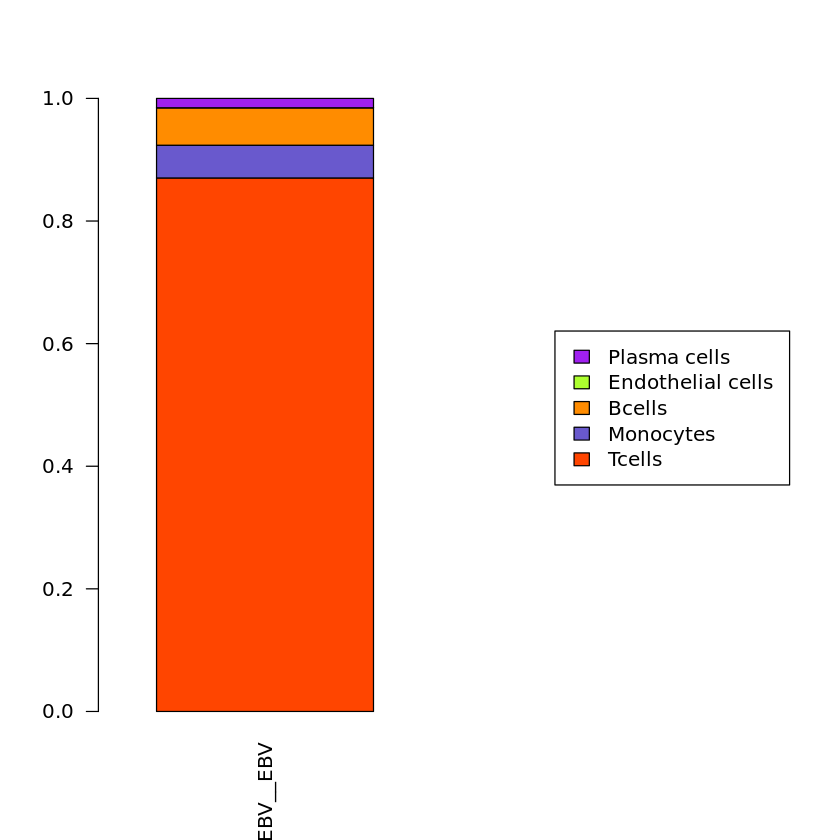

In [96]:
barplot(height=freq_table,width = 20,xlim=c(1,60),col =clustcol,legend = rownames(freq_table),args.legend = list(x = "right"),las=2,xlab="")

In [97]:
pdf(file = "percentage.pdf",width =12,height = 15)
barplot(height=freq_table,width = 20,xlim=c(1,60),col =clustcol,legend = rownames(freq_table),args.legend = list(x = "right"),las=2,xlab="")
dev.off()

png 
  2